In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

from ECGDataset import ECGDataset

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
window_size = 180

train_ds= ECGDataset(f"data/generated/timeGAN_train_normal_180", f"data/train_labels_{window_size}.csv")


test_normal_ds = ECGDataset(f"data/normal_test{window_size}.csv", f"data/normal_labels_{window_size}.csv")
test_anomalie_ds = ECGDataset(f"data/anomalie_test{window_size}.csv", f"data/anomalie_labels_{window_size}.csv")
val_ds = ECGDataset(f"data/normal_val_{window_size}.csv", f"data/val_labels_{window_size}.csv")


In [4]:
train_ds.y

[['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],


['N']

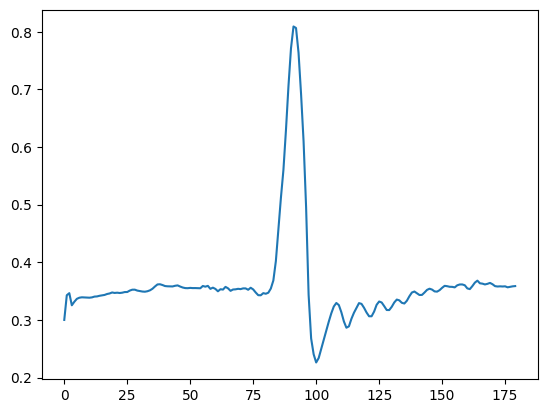

In [6]:
plt.plot(train_ds.df[1])
train_ds.y[0]

In [7]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    val_losses = []

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset)

    size = len(train_dl.dataset)
    for batch, (X,y) in enumerate(train_dl):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X).unsqueeze(0)
        loss = criterion(pred, X)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for (seq_true, y) in val_dl:
        seq_true = seq_true.to(device)   # putting sequence to gpu
        seq_pred = model(seq_true).unsqueeze(0)    # prediction

        loss = criterion(seq_pred, seq_true)  # recording loss

        val_losses.append(loss.item())    # storing loss into the validation losses

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history

In [8]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(180, 1, device, 32)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [9]:
model, history = train_model(
  model, 
  train_dataset=train_ds, 
  val_dataset=val_ds,
  n_epochs=10,
  lr=3e-4,
  batch_size=1
)

loss: 62.320801  [    1/71253]
loss: 5.663899  [10001/71253]
loss: 4.130177  [20001/71253]
loss: 3.783474  [30001/71253]
loss: 1.626598  [40001/71253]
loss: 6.762304  [50001/71253]
loss: 1.855528  [60001/71253]
loss: 2.368314  [70001/71253]
Epoch 1: train loss = 4.368273666200692, val loss = 8.139486430569953
loss: 1.689766  [    1/71253]
loss: 2.751883  [10001/71253]
loss: 1.074965  [20001/71253]
loss: 3.455832  [30001/71253]
loss: 1.274647  [40001/71253]
loss: 3.220519  [50001/71253]
loss: 2.104083  [60001/71253]
loss: 1.728765  [70001/71253]
Epoch 2: train loss = 2.4439236191186264, val loss = 8.404477461506303
loss: 1.497502  [    1/71253]
loss: 2.084755  [10001/71253]
loss: 3.976978  [20001/71253]
loss: 2.157087  [30001/71253]
loss: 2.480564  [40001/71253]
loss: 2.712592  [50001/71253]
loss: 2.045836  [60001/71253]
loss: 4.422155  [70001/71253]
Epoch 3: train loss = 2.4016517947742786, val loss = 8.264549853525308
loss: 5.469386  [    1/71253]
loss: 2.740265  [10001/71253]
loss: 1

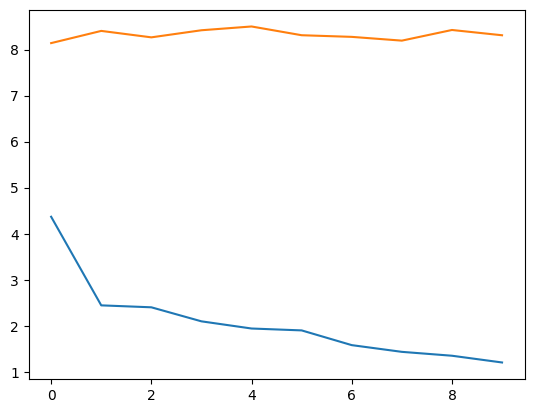

In [10]:
plt.plot(history["train"])
plt.plot(history["val"])

In [10]:
torch.save(model.state_dict(), "models/lstmae_180_embed32.pth")

In [12]:
model.load_state_dict(torch.load("models/lstmae_5000.pth", map_location=torch.device('cpu')))
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [10]:
model = model.to(device="cpu")

In [12]:
train_ds.__getitem__(0)

(tensor([[0.5104],
         [0.5096],
         [0.5096],
         [0.5078],
         [0.5070],
         [0.5070],
         [0.5061],
         [0.5035],
         [0.5043],
         [0.5052],
         [0.5078],
         [0.5087],
         [0.5104],
         [0.5104],
         [0.5113],
         [0.5104],
         [0.5113],
         [0.5104],
         [0.5113],
         [0.5130],
         [0.5183],
         [0.5200],
         [0.5235],
         [0.5261],
         [0.5278],
         [0.5278],
         [0.5278],
         [0.5287],
         [0.5278],
         [0.5270],
         [0.5270],
         [0.5287],
         [0.5252],
         [0.5261],
         [0.5261],
         [0.5261],
         [0.5252],
         [0.5226],
         [0.5191],
         [0.5165],
         [0.5122],
         [0.5113],
         [0.5087],
         [0.5070],
         [0.5052],
         [0.5043],
         [0.5009],
         [0.5009],
         [0.5000],
         [0.5035],
         [0.5035],
         [0.5009],
         [0.

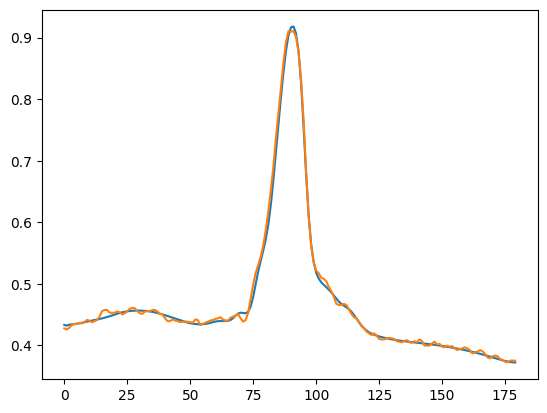

In [11]:
plt.plot(model(test_normal_ds.__getitem__(12)[0]).cpu().detach().numpy().squeeze())
plt.plot(test_normal_ds.__getitem__(12)[0].cpu().detach().numpy().squeeze())

In [12]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [13]:
model = model.to(device)

In [15]:
_, losses_test_normal = predict(model, test_normal_ds)

(array([4.830e+02, 1.763e+03, 1.754e+03, 1.480e+03, 1.035e+03, 6.710e+02,
        4.810e+02, 3.120e+02, 2.160e+02, 1.490e+02, 8.000e+01, 8.400e+01,
        5.800e+01, 4.100e+01, 3.400e+01, 3.100e+01, 2.100e+01, 2.100e+01,
        1.700e+01, 6.000e+00, 9.000e+00, 8.000e+00, 3.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

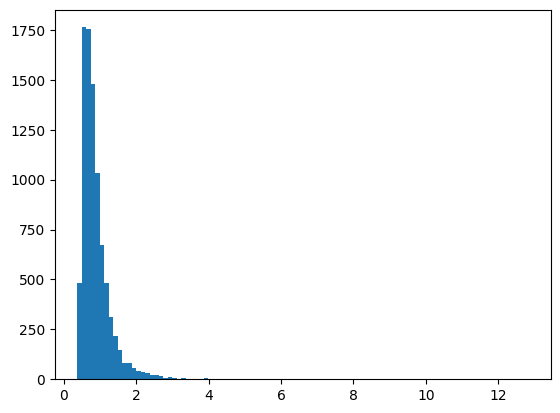

In [16]:
plt.hist(losses_test_normal, bins=100)

In [17]:
THRESHOLD = 2.5

In [18]:
correct = sum(l <= THRESHOLD for l in losses_test_normal)
print(f'Correct normal predictions: {correct}/{len(test_normal_ds)} or  {correct/len(test_normal_ds)}')

Correct normal predictions: 8694/8797 or  0.9882914629987496


In [19]:
_, losses_test_anomaly = predict(model, test_anomalie_ds)

(array([3.100e+03, 4.641e+03, 3.610e+03, 2.221e+03, 8.820e+02, 1.073e+03,
        1.455e+03, 1.187e+03, 7.890e+02, 6.010e+02, 4.790e+02, 3.080e+02,
        1.860e+02, 1.570e+02, 1.070e+02, 8.200e+01, 6.100e+01, 4.500e+01,
        4.300e+01, 5.500e+01, 6.500e+01, 4.100e+01, 4.700e+01, 3.800e+01,
        2.300e+01, 1.600e+01, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 0.40483421,  1.39462159,  2.38440897,  3.37419635,  4.36398373,
         5.35377111,  6.34355849,  7.33334587,  8.32313325,  9.31292063,
        10.30270801, 11.29249539, 12.28228276, 13.27207014, 14.26185752,
        15.2516449 , 16.24143228, 17.23121966, 18.22100704, 19.21079442,
        20.2005818 , 21.19036918, 22.18015656, 23.16994394, 24.15973132,
        25.

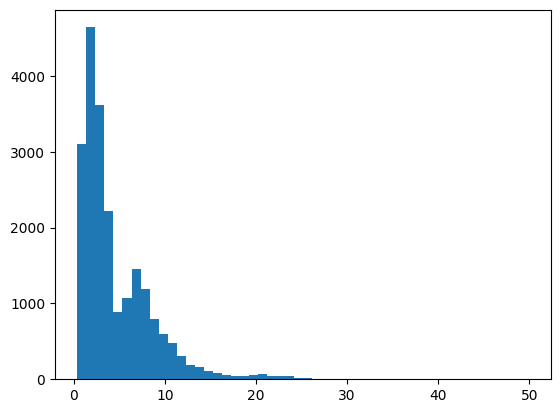

In [20]:
plt.hist(losses_test_anomaly, bins=50)

In [21]:
correct = sum(l > THRESHOLD for l in losses_test_anomaly)
print(f'Correct anomaly predictions: {correct}/{len(test_anomalie_ds)} or  {correct/len(test_anomalie_ds)}')

Correct anomaly predictions: 13200/21326 or  0.6189627684516552


In [22]:
def find_threshold(loss_normal, loss_anomaly):
    threshold_list = np.linspace(0,5,21)
    corr_normal = []
    corr_anomaly = []
    for th in threshold_list:
        corr_normal.append(sum(l <= th for l in loss_normal)/len(loss_normal))
        corr_anomaly.append(sum(l > th for l in loss_anomaly)/len(loss_anomaly))
    return corr_normal, corr_anomaly

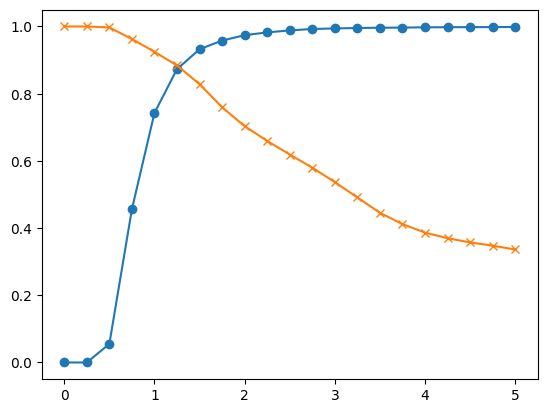

In [34]:
p1, p2= find_threshold(losses_test_normal, losses_test_anomaly)
plt.plot(np.linspace(0,5,21), p1, marker="o")
plt.plot(np.linspace(0,5,21), p2, marker="x")

In [24]:
def predict_classes(model, dataset, threshold=1.25):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            pred = "N" if loss <= threshold else "A"
            predictions.append(pred)
            losses.append(loss.item())
    return predictions

In [31]:
from sklearn import metrics
    
pred_normal = predict_classes(model, test_normal_ds, threshold=1.2)
pred_anomaly = predict_classes(model, test_anomalie_ds, threshold=1.2)

In [32]:
print(f"Acc: {metrics.accuracy_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly)}")
print(f"Precision: {metrics.precision_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"Recall: {metrics.recall_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"F1: {metrics.f1_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")

Acc: 0.8808883577332935
Precision: 0.7657381899806143
Recall: 0.8531317494600432
F1: 0.807076029680611
